In [1]:
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib widget
from joblib import Parallel, delayed
from scipy.optimize import curve_fit
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Computer Modern",
    "figure.dpi": 100
})



from Finite_volume_method_1D import *

In [2]:
chippath = '../../DataKian/bTa_LT278W2chip5/'
filename = 'KID3_96dBm__TmK20_avgpulse_ampphase.csv'
length = 90
simtime = 300
dtinit=0.001
dxfrac=1/4

lambdasinnm = [402,673,986,1545]

KIDdict = {}
for lambdanm in lambdasinnm:
    KIDdict[lambdanm] = KID_data(chippath,lambdanm,filename,length)
    KIDdict[lambdanm].fit_tail(showplots=False)
for lambdanm in lambdasinnm:
    KIDdict[lambdanm] = KID_data(chippath,lambdanm,filename,length)
    KIDdict[lambdanm].fit_tail(start=200,showplots=False)

In [3]:
Ls=[]
for lambdanm in lambdasinnm:
    print(KIDdict[lambdanm].tauqpstar,KIDdict[lambdanm].tauqpstarstd)
    print(KIDdict[lambdanm].L)
    Ls.append(KIDdict[lambdanm].L)
L=np.mean(Ls) # use the same linear decay rate for all wavelengths

194.88850185176454 2.2767849027049727
0.005131139038467322
201.89787714954562 3.9613091250212302
0.004952999081111193
191.8028632586559 3.097737438872922
0.005213686506084371
190.54199588046978 6.5199494193543215
0.0052481868649435


In [4]:
def prep_data(neg_offset):
    ylist = []
    for lambdanm in lambdasinnm:
        xfit = np.arange(neg_offset,neg_offset+simtime-KIDdict[lambdanm].dt/2,KIDdict[lambdanm].dt)
        indmin = np.argmax(KIDdict[lambdanm].phase)+neg_offset
        indmax = indmin + simtime
        ylist.append(KIDdict[lambdanm].phase[indmin:indmax])
    yfit = np.array(ylist).ravel()
    return xfit, yfit

def func_to_parallelize(t,params):
     SIM = KID_sim(params,dtinit,dxfrac,simtime_approx=simtime,D_const=False)
     return np.interp(t,SIM.t_axis_interp,SIM.phaseintime)

def fitfunc(t,eta,sigma,tau,Q0):
    print('eta (-):\t',eta)
    print('sigma (um):\t',sigma)
    print('tau (us):\t',tau)
    print('Q0 (um-1):\t',Q0)
    datalist = Parallel(n_jobs=len(lambdasinnm))(delayed(func_to_parallelize)(t,KID_params(eta_pb=eta,sigma_IC=sigma,trickle_time=tau,Q0=Q0,KID=KIDdict[lambdanm],L=L)) for lambdanm in lambdasinnm)
    return np.concatenate(datalist)

def par_func_plot(params):
     SIM = KID_sim(params,dtinit,dxfrac,simtime_approx=simtime,D_const=False)
     return SIM

def plotsim(eta,sigma,tau,Q0):
    datalist = Parallel(n_jobs=4)(delayed(par_func_plot)(KID_params(eta_pb=eta,sigma_IC=sigma,trickle_time=tau,Q0=Q0,KID=KIDdict[lambdanm],L=L)) for lambdanm in lambdasinnm)
    plotdata = {}
    for obj,lambdanm in zip(datalist,lambdasinnm):
         plotdata[lambdanm]=obj
    return plotdata

In [5]:
xfit,yfit=prep_data(-10) #e.g. -5 means take 5 data points before the max into account for the data
popt, pcov = curve_fit(fitfunc,xfit,yfit,p0=[0.59,1,3,0.5],bounds=[[0.01,0.5,0.01,0.1],[1,length/6,10,np.inf]])
print('Done!')

eta (-):	 0.59
sigma (um):	 1.0
tau (us):	 3.0
Q0 (um-1):	 0.5
Warning! When using a trickle_time, sigma_IC must be small enough compared to absorber length. Otherwise qps are 'lost' outside the borders of the domain.
Warning! When using a trickle_time, sigma_IC must be small enough compared to absorber length. Otherwise qps are 'lost' outside the borders of the domain.
Warning! When using a trickle_time, sigma_IC must be small enough compared to absorber length. Otherwise qps are 'lost' outside the borders of the domain.
Iteration: 0	Simtime (us): 0.001Warning! When using a trickle_time, sigma_IC must be small enough compared to absorber length. Otherwise qps are 'lost' outside the borders of the domain.
Iteration: 9177	Simtime (us): 300.08123788479184
Iteration: 10963	Simtime (us): 300.00517254020906
Iteration: 12427	Simtime (us): 300.09919737513625
Iteration: 14321	Simtime (us): 300.02760224279825
eta (-):	 0.5900000149011612
sigma (um):	 1.0
tau (us):	 3.0
Q0 (um-1):	 0.5
Warning! 

In [9]:
# Display parameters, standard deviation, and correlation coefficient
parameters = ['eta','sigma','tau','Q0']
print("Parameters:")
for name, param, std in zip(parameters,popt,np.sqrt(np.diag(pcov))):
    print(f"{name}:\t{param:.10f}\t+/-\t{std:.10f}")

print("\nCorrelation Coefficients:")
for i in range(len(popt)):
    for j in range(i+1, len(popt)):
        print(f"{parameters[i]} vs {parameters[j]}: {pcov[i,j]/np.prod(np.sqrt(pcov[i,i]*pcov[j,j])):.10f}")

#Output:


Parameters:
eta:	0.8717105897	+/-	0.0011412553
sigma:	11.8772055795	+/-	0.0463442580
tau:	1.8080663053	+/-	0.0005310352
Q0:	0.5728312067	+/-	0.0011352580

Correlation Coefficients:
eta vs sigma: 0.9930489124
eta vs tau: -0.0538458676
eta vs Q0: -0.9312592990
sigma vs tau: -0.0364483773
sigma vs Q0: -0.9519198271
tau vs Q0: -0.2619724916


In [10]:
simdata = plotsim(popt[0],popt[1],popt[2],popt[3])

Warning! When using a trickle_time, sigma_IC must be small enough compared to absorber length. Otherwise qps are 'lost' outside the borders of the domain.
Warning! When using a trickle_time, sigma_IC must be small enough compared to absorber length. Otherwise qps are 'lost' outside the borders of the domain.
Warning! When using a trickle_time, sigma_IC must be small enough compared to absorber length. Otherwise qps are 'lost' outside the borders of the domain.
Warning! When using a trickle_time, sigma_IC must be small enough compared to absorber length. Otherwise qps are 'lost' outside the borders of the domain.
Iteration: 6118	Simtime (us): 300.08234115734352
Iteration: 8875	Simtime (us): 300.17259071907476
Iteration: 9981	Simtime (us): 300.13416555382327
Iteration: 11359	Simtime (us): 300.06059034647343


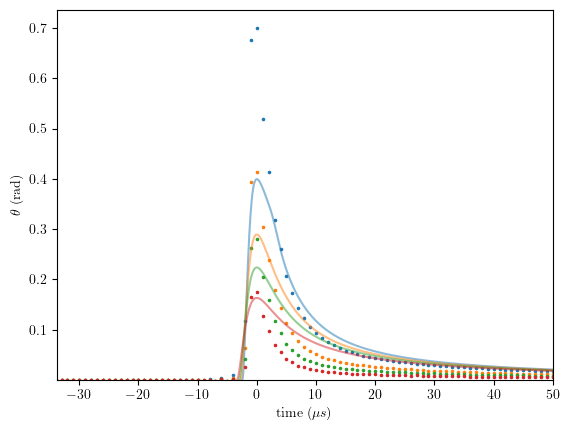

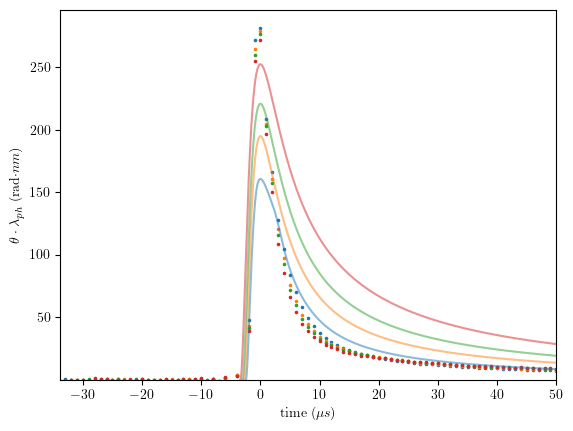

In [11]:
lambdasinnm = [402,673,986,1545]
plt.figure()
for lambdanm in lambdasinnm:
    phase = KIDdict[lambdanm].phase
    t = KIDdict[lambdanm].t_full
    t -= t[np.argmax(phase)]
    plt.plot(simdata[lambdanm].t_axis_interp,simdata[lambdanm].phaseintime,alpha=0.5)
    plt.scatter(t,phase,marker='.',s=10)
plt.xlim(10*simdata[lambdanm].t_start,50)
plt.ylim(1e-3)
plt.xlabel(r'time ($\mu s$)')
plt.ylabel(r'$\theta$ (rad)')
#plt.semilogy()
plt.show()
plt.figure()
for lambdanm in lambdasinnm:
    phase = KIDdict[lambdanm].phase
    t = KIDdict[lambdanm].t_full
    t -= t[np.argmax(phase)]
    plt.plot(simdata[lambdanm].t_axis_interp,simdata[lambdanm].phaseintime*lambdanm,alpha=0.5)
    plt.scatter(t,phase*lambdanm,marker='.',s=10)
plt.xlim(10*simdata[lambdanm].t_start,50)
plt.ylim(1e-4)
plt.xlabel(r'time ($\mu s$)')
plt.ylabel(r'$\theta\cdot\lambda_{ph}$ (rad$\cdot nm$)')
#plt.semilogy()
plt.show()